# The Persistent Algorithm

The most common baseline method for supervised machine learning is the Zero Rule algorithm, which predicts the majority class in the case of classification, or the average outcome in the case of regression. We could use this approach for time series, however we would not respect the serial correlation structure in time series datasets.

The equivalent technique for use with time series dataset is the **persistent algorithm**.

The persistent algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

$$\hat{y}_{t+1} = y_{t}$$
$$\hat{y}_{t+2} = y_{t+1}$$
$$...$$
$$\hat{y}_{t+n+1} = y_{t+n}$$ 

This satisfies the three main conditions for a good technique to be a baseline forecast:

- *Simple*: A method that requires little or no training or intelligence.
- *Fast*: A method that is fast to implement and computationally trivial to make a prediction.
- *Repeatable*: A method that is deterministic, meaning that it produces an expected output given the same input.

To make this concrete, let's take a look at how to develop a persistent model and use it to establish a baseline performance for the usual Airline Passenger dataset.

In [1]:
import warnings

from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.api import Holt, ExponentialSmoothing

%matplotlib inline

In [2]:
# import data
data_set = pd.read_csv('data/airline_passengers.csv',infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

In [3]:
# function to evaluate the models
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(y_true, y_pred):
    print("MAE:",mae(y_true, y_pred))
    print("MSE:", mse(y_true, y_pred))
    print("RMSE:", np.sqrt(mse(y_true, y_pred)))
    print("MAPE:", mape(y_true, y_pred))

As usual, we split the dataset in train and test:

In [4]:
train = data_set[:'1957-01-01'].copy().rename(columns={"Thousands of Passengers": "train"})
test = data_set['1957-01-02':].copy().rename(columns={"Thousands of Passengers": "test"})

In order to make the predictions of the Persistent model, we just have to **shift** the data 1 points backwards:

In [5]:
test['Persistent'] = test['test'].shift(1)
evaluate(test['test'][1:], test['test'].shift(1)[1:])

MAE: 41.28260869565217
MSE: 2402.282608695652
RMSE: 49.01308609642584
MAPE: 9.87598070824141


In order to have a comparison, let's go back to the performance of the Holt and the Holt-Winters models:

In [6]:
warnings.filterwarnings("ignore") # suppress warnings

fitHolt = Holt(train['train']).fit(smoothing_level = 0.2,smoothing_trend = 0.05)
test['Holt'] = fitHolt.forecast(len(test))

In [7]:
evaluate(test['test'], test['Holt'])

MAE: 51.69007385588371
MSE: 4774.377208871444
RMSE: 69.09686830002822
MAPE: 11.635357567368738


In [8]:
warnings.filterwarnings("ignore") # suppress warnings

fitTES = ExponentialSmoothing(train['train'] ,seasonal_periods=12 ,trend='add', seasonal='add',use_boxcox=True,initialization_method="estimated").fit()
test['Holt-Winters'] = fitTES.forecast(len(test))

In [9]:
evaluate(test['test'], test['Holt-Winters'])

MAE: 37.72878685835209
MSE: 2004.9248687831064
RMSE: 44.77638740210186
MAPE: 9.27639976383433


By looking at the results, we can see that the Persistent method outperform the Holt technique and it does only slightly worst than the Holt-Winters. Such a simple technique, with essentialy no training phase, is able to almost outperform even the Holt-Winters. Let's see also the plot of the forecast:

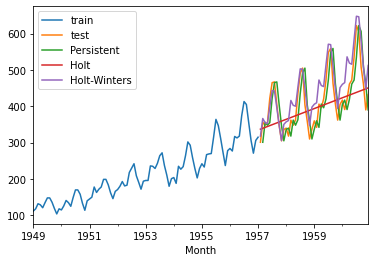

In [10]:
ax = train.plot()
test.plot(ax=ax)
plt.show()

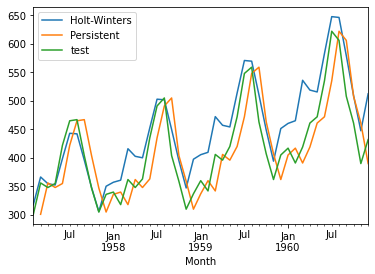

In [11]:
test[['Holt-Winters','Persistent','test']].plot()
plt.show()

By looking at the plots we can note that the Persistent forecasts are obviously equal to the test data, just one data point shifted. How is it possible that such a simple model is able to performing so well?